In [1]:
import os
import time
import shutil
import math
import random

import numpy as np
import open3d as o3
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms.functional as T
import imageio

from PIL import Image
from scipy.io import loadmat
from scipy.spatial.transform import Rotation
from mpl_toolkits.mplot3d import Axes3D

from pathlib import Path
from typing import Callable, Optional
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm import tqdm_notebook

## Projection

Quaternion functions:

In [2]:
def points2quat(v):
    "Convert xyz points to quaternions"
    assert len(v.shape) == 3
    assert v.size(-1) == 3
    return F.pad(v, (1, 0, 0, 0))

def quatmul(q1, q2):
    "Multiply quaternions"
    w1, x1, y1, z1 = torch.unbind(q1, dim=-1)
    w2, x2, y2, z2 = torch.unbind(q2, dim=-1)

    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return torch.stack([w, x, y, z], dim=-1)

def quatconj(q):
    "Conjugate of quaternion"
    m = q.new(4).fill_(-1)
    m[0] = 1.0
    return q * m 

def quatrot(v, q, inverse=False):
    "Rotate points v [b, n, 3] with quaternions q [b, 4]"
    q = F.normalize(q, dim=-1)
    q = q[:, None, :]
    q_ = quatconj(q)
    v = points2quat(v)

    if inverse:
        wxyz = quatmul(quatmul(q_, v), q)
    else:
        wxyz = quatmul(quatmul(q, v), q_)
        
    if len(wxyz.shape) == 2:
        wxyz = wxyz.unsqueeze(0)

    return wxyz[:, :, 1:4]

In [3]:
def pc_camera_transform(pc, rotation, focal_lenght=1.875, camera_distance=2.0):
    "Transform pontcloud `pc` to camera coordinates with `rotation`"
    
    pc = quatrot(pc, rotation)
    zs, ys, xs = torch.unbind(pc, dim=2)
    
    xs = xs * focal_lenght / (zs + camera_distance)
    ys = ys * focal_lenght / (zs + camera_distance)
    
    return torch.stack([zs, ys, xs], dim=2)

In [4]:
def pc_voxels(pc, size=64, eps=1e-6):
    "Create voxels of `[size]*3` from pointcloud `pc`"
    # save for later
    vox_size = pc.new(3).fill_(size)
    bs = pc.size(0)
    n = pc.size(1)
    
    # check borders
    valid = ((pc < 0.5 - eps) & (pc > -0.5 + eps)).all(dim=-1).view(-1)
    grid = (pc + 0.5) * (vox_size - 1)
    grid_floor = grid.floor()

    grid_idxs = grid_floor.long()
    batch_idxs = torch.arange(bs)[:, None, None].repeat(1, n, 1).to(pc.device)
    # idxs of form [batch, z, y, x] where z, y, x discretized indecies in voxel
    idxs = torch.cat([batch_idxs, grid_idxs], dim=-1).view(-1, 4)
    idxs = idxs[valid]

    # trilinear interpolation
    r = grid - grid_floor
    rr = [1. - r, r]
    voxels = []

    def trilinear_interp(pos):
        update = rr[pos[0]][..., 0] * rr[pos[1]][..., 1] * rr[pos[2]][..., 2]
        update = update.view(-1)[valid]
        
        shift_idxs = torch.LongTensor([[0] + pos]).to(pc.device)
        shift_idxs = shift_idxs.repeat(idxs.size(0), 1)
        update_idxs = idxs + shift_idxs
        valid_shift = update_idxs < size

        voxels = pc.new(bs, size, size, size).fill_(0)
        voxels.index_put_(torch.unbind(update_idxs, dim=1), update, accumulate=True)

        return voxels
        
    
    for k in range(2):
        for j in range(2):
            for i in range(2):
                voxels.append(trilinear_interp([k, j, i]))
    
    return torch.stack(voxels).sum(dim=0).clamp(0, 1)

In [5]:
def smoothing_kernel(sigma, kernel_size=21):
    "Generate 3 separate gaussian kernels with `sigma` stddev"
    x = torch.arange(-kernel_size//2 + 1., kernel_size//2 + 1., device=sigma.device)
    kernel_1d = torch.exp(-x**2 / (2. * sigma**2))
    kernel_1d = kernel_1d / kernel_1d.sum()

    k1 = kernel_1d.view(1, 1, 1, 1, -1)
    k2 = kernel_1d.view(1, 1, 1, -1, 1)
    k3 = kernel_1d.view(1, 1, -1, 1, 1)
    return [k1, k2, k3]

def voxels_smooth(voxels, kernels, scale=None):
    "Apply gaussian blur to voxels with separable `kernels` then `scale`"
    assert isinstance(kernels, list)
    
    # add fake channel for convs
    voxels = voxels.unsqueeze(1)

    for k in kernels:
        # add padding for kernel dimension
        padding = [0] * 3
        padding[np.argmax(k.shape) - 2] = max(k.shape) // 2

        voxels = F.conv3d(voxels, k, stride=1, padding=padding)
    
    voxels = voxels.squeeze(1)

    if scale is not None:
        voxels = voxels * scale.view(-1, 1, 1, 1)
        voxels = voxels.clamp(0, 1)

    return voxels

In [6]:
def drc_prob(voxels, clip_val=1e-5):
    "Compute termination probabilities from part 4 https://arxiv.org/pdf/1810.09381.pdf"
    inp = voxels.permute(1, 0, 2, 3)
    inp = inp.clamp(clip_val, 1.0 - clip_val)
    zero = voxels.new(1, inp.size(1), inp.size(2), inp.size(3)).fill_(clip_val)

    y = torch.log(inp)
    x = torch.log(1 - inp)

    r = torch.cumsum(x, dim=0)
    p1 = torch.cat([zero, r], dim=0)
    p2 = torch.cat([y, zero], dim=0)

    p = p1 + p2
    return torch.exp(p).permute(1, 0, 2, 3)

In [7]:
class Projection(nn.Module):
    "Diffefentiable point cloud projection module"
    def __init__(self, vox_size=64, smooth_ks=21, smooth_sigma=3.0):
        super().__init__()
        self.vox_size = vox_size
        self.ks = smooth_ks
        self.register_buffer('sigma', torch.tensor(smooth_sigma))

    def forward(self, pc, rotation, scale=None):
        "Project points `pc` to camera givne by `transform`"
        pc = pc_camera_transform(pc, rotation)
        voxels = pc_voxels(pc, self.vox_size)
        smooth = voxels_smooth(voxels, kernels=smoothing_kernel(self.sigma, self.ks), scale=scale)
        prob = drc_prob(smooth)
        proj = prob[:, :-1].sum(1).flip(1)
        
        return proj

In [8]:
p = Projection(smooth_sigma=0.5)

In [9]:
# plt.imshow(p(points_t.repeat(3, 1, 1), camera_t.repeat(3, 1), torch.tensor([0.5, 1, 10]))[2]);

In [10]:
class PointCloudDropout(nn.Module):
    "Drop random portions of pointclouds `pc`"
    def __init__(self, keep_prob=0.1):
        super().__init__()
        self.keep_prob = keep_prob
        
    def forward(self, pc):
        bs, n_points = pc.size(0), pc.size(1)
        n_keep = math.ceil(n_points * self.keep_prob)

        batch_idxs = repeat_tensor_batch(torch.arange(bs), n_keep)
        point_idxs = torch.cat([torch.randperm(n_points)[:n_keep] for i in range(bs)])

        return pc[batch_idxs, point_idxs].view(bs, n_keep, -1)

### Test

In [11]:
pc = torch.rand(10, 10, 3)

In [12]:
pc[0]

tensor([[0.8016, 0.3937, 0.5869],
        [0.9904, 0.5714, 0.5151],
        [0.8951, 0.3505, 0.0638],
        [0.3532, 0.9637, 0.4313],
        [0.3508, 0.2330, 0.5721],
        [0.2510, 0.5082, 0.5600],
        [0.0383, 0.7441, 0.0246],
        [0.4372, 0.4954, 0.2316],
        [0.5616, 0.0978, 0.2810],
        [0.1153, 0.6881, 0.5294]])

## Basic model blocks (with camera supervision)

In [14]:
def conv_block(in_ch, out_ch, ks=3, stride=1, padding=1, bn=False, act=True):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, ks, stride, padding, bias=not bn),
        nn.ReLU(True) if act else nn.Identity(),
        nn.BatchNorm2d(out_ch) if bn else nn.Identity(),
    )

def weight_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight.data, a=0)


class Encoder(nn.Module):
    "Encodes input images"
    def __init__(self, img_size, hidden_dim):
        super().__init__()
        self.convs = nn.Sequential(                       
            conv_block(3, 16, ks=5, stride=2, padding=2),  
            conv_block(16, 16, ks=3, stride=2),            
            conv_block(16, 16, ks=3, stride=1),          
            conv_block(16, 16, ks=3, stride=2),           
            conv_block(16, 16, ks=3, stride=1),
            conv_block(16, 16, ks=3, stride=2),           
            conv_block(16, 16, ks=3, stride=1),
            conv_block(16, 16, ks=3, stride=2),          
            conv_block(16, 16, ks=3, stride=1),
        )
        
        self.features = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 16, 1024),
            nn.ReLU(True),
            # nn.BatchNorm1d(1024),
            nn.Linear(1024, 1024),
        )

    def forward(self, img):
        conv_features = self.convs(img)
        features = self.features(conv_features)
        
        return features

In [15]:
class Decoder(nn.Module):
    def __init__(self, hidden_dim, num_points, predict_scale=True):
        super().__init__()
        self.num_points = num_points
        self.predict_scale = predict_scale
        self.pc_decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim, bias=False),
            nn.ReLU(True),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, num_points * 3),
        )
        
        self.scale_decoder = nn.Linear(hidden_dim, 1)
        
    def forward(self, z):
        "Transform hidden vector to pointcloud"
        # predict pointcloud
        pc = self.pc_decoder(z)
        pc = pc.view(-1, self.num_points, 3)
        pc = torch.tanh(pc) / 2.0

        scale = None
        if self.predict_scale:
            scale = self.scale_decoder(z)
            scale = torch.sigmoid(scale)

        return pc, scale

In [16]:
def repeat_tensor_batch(tensor, times):
    "Repeat tensor `times` times for each element in batch"
    if tensor is None: return

    data_shape = tensor.shape[1:]
    repeats = [1, times] + [1] * len(data_shape)

    expanded = tensor.unsqueeze(1).repeat(*repeats)
    return expanded.view(-1, *data_shape)


class SimpleModel(nn.Module):
    "Basic model"
    def __init__(
        self, img_size=128, hidden_dim=1024, num_points=8000, 
        vox_size=64, smooth_sigma=3.0, predict_scale=True, keep_prob=0.1,
    ):
        super().__init__()
        self.encoder = Encoder(img_size, hidden_dim)
        self.decoder = Decoder(hidden_dim, num_points, predict_scale)
        self.pc_dropout = PointCloudDropout(keep_prob)
        self.pc_projection = Projection(vox_size, smooth_sigma=smooth_sigma)

        self.encoder.apply(weight_init)
        self.decoder.apply(weight_init)

    def forward(self, imgs, cameras):
        "Generate new view of `imgs` from `cameras` using differentiable projection"
        num_views = cameras.size(0) // imgs.size(0)

        # Point cloud generation
        z = self.encoder(imgs)
        pc, scale = self.decoder(z)

        pc    = repeat_tensor_batch(self.pc_dropout(pc), num_views)
        scale = repeat_tensor_batch(scale, num_views)
        proj  = self.pc_projection(pc, cameras, scale)
        
        # store for visualizations and tests
        self.pc   = pc.detach()
        self.proj = proj.detach()

        return proj

### Tests

In [17]:
x = torch.rand(2, 5, 2) * 10
x

tensor([[[7.0451, 1.5773],
         [9.4161, 8.0631],
         [3.9830, 2.5171],
         [9.4450, 2.9773],
         [5.0436, 5.8415]],

        [[2.2411, 8.6125],
         [5.4823, 1.5001],
         [0.4438, 1.4560],
         [0.8089, 4.8278],
         [9.3225, 2.2402]]])

In [18]:
repeat_tensor_batch(x, 2)

tensor([[[7.0451, 1.5773],
         [9.4161, 8.0631],
         [3.9830, 2.5171],
         [9.4450, 2.9773],
         [5.0436, 5.8415]],

        [[7.0451, 1.5773],
         [9.4161, 8.0631],
         [3.9830, 2.5171],
         [9.4450, 2.9773],
         [5.0436, 5.8415]],

        [[2.2411, 8.6125],
         [5.4823, 1.5001],
         [0.4438, 1.4560],
         [0.8089, 4.8278],
         [9.3225, 2.2402]],

        [[2.2411, 8.6125],
         [5.4823, 1.5001],
         [0.4438, 1.4560],
         [0.8089, 4.8278],
         [9.3225, 2.2402]]])

## Datasets

We use splits as authors. For now we use camera supervision so in addition to images we load camera positions as quaternions

In [19]:
def quat_from_campos(pos):
    "Convert blender camera format `pos` to torch tensor quaternion [w, x, y, z]"
    cx, cy, cz = pos[0]
    camDist = math.sqrt(cx * cx + cy * cy + cz * cz)
    cx = cx / camDist
    cy = cy / camDist
    cz = cz / camDist
    t = math.sqrt(cx * cx + cy * cy)
    tx = cx / t
    ty = cy / t
    yaw = math.acos(tx)
    if ty > 0:
        yaw = 2 * math.pi - yaw

    roll = 0
    pitch = math.asin(cz)
    yaw = yaw + math.pi

    quat = Rotation.from_euler("yzx", [yaw, pitch, roll]).as_quat()
    quat = np.r_[quat[-1], quat[:-1]]

    return torch.tensor(quat.astype(np.float32))


def get_models(shapenet_id="03001627", split="train"):
    "Read model paths from split file"

    assert split in ("train", "valid")
    split = f"{shapenet_id}.{split}"
    path = Path(shapenet_id)

    with open(split) as models:
        return [path/m.strip() for m in models]


class Shapenet(data.Dataset):
    "Dataset with renders and camera views for shapenet category"
    def __init__(self, models, num_views=5):
        assert 1 <= num_views <= 5

        self.num_views = num_views
        self.models = models

    def __getitem__(self, idx):
        model = self.models[idx]
        images = []
        masks = []
        cameras = []

        for name in sorted(os.listdir(model)):
            if name.startswith("render"):
                o = np.array(Image.open(model/name))
                mask = o[..., -1].astype(np.float32) / 255.
                img = o[..., :-1].astype(np.float32) / 255.
                
                images.append(torch.tensor(img).permute(2, 0, 1))
                masks.append(torch.tensor(mask))
                
            if name.startswith("camera"):
                camera = loadmat(model/name)
                cameras.append(quat_from_campos(camera["pos"]))
        
        images = torch.stack(images)
        cameras = torch.stack(cameras)
        masks = torch.stack(masks)

        return images, cameras, masks
    
    def __len__(self):
        return len(self.models)

Load chairs if needed

In [22]:
!wget --quiet --show-progress "https://datasets.d2.mpi-inf.mpg.de/unsupervised-shape-pose/03001627-renders.tar.gz"

03001627-renders.ta 100%[===================>] 431.65M  4.31MB/s    in 78s     


In [24]:
!tar -xzf "03001627-renders.tar.gz"

In [26]:
train_ds = Shapenet(get_models(split="train"), num_views=5)
valid_ds = Shapenet(get_models(split="valid"), num_views=5)

In [27]:
def multi_view_collate(batch):
    "Prepare batch with 1 image and n_views masks and cameras per item"
    bs = len(batch)
    n_views = batch[0][0].size(0)

    idxs = torch.randint(0, n_views, size=(bs,))
    imgs, cams, masks = zip(*[(img[i], cam, mask) for (img, cam, mask), i in zip(batch, idxs)])

    imgs = torch.stack(imgs)
    masks = torch.cat(masks, dim=0)
    cams = torch.cat(cams, dim=0)

    return imgs, cams, masks

### Tests

In [20]:
train_dl = data.DataLoader(train_ds, batch_size=10, shuffle=True, collate_fn=multi_view_collate, drop_last=True)

In [21]:
imgs, cams, masks = next(iter(train_dl))

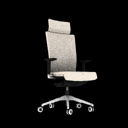

In [22]:
T.to_pil_image(imgs[0])

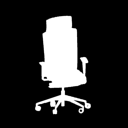

In [23]:
T.to_pil_image(masks[3])

In [29]:
cams[3]

tensor([-0.5393, -0.1167, -0.8305,  0.0758])

Test the model

In [36]:
model = SimpleModel(img_size=128, smooth_sigma=3.0)

In [38]:
model.cuda();

In [40]:
%%time
proj = model.forward(imgs.cuda(), cams.cuda())

CPU times: user 400 ms, sys: 38.6 ms, total: 438 ms
Wall time: 114 ms


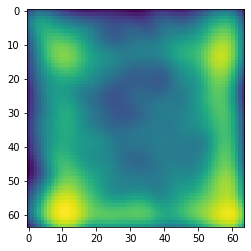

In [41]:
plt.imshow(proj[4].detach().cpu());

## Training

Lets try to overfit one example and see what happens

### Tests

In [29]:
train_ds = Shapenet(get_models(split="train"), num_views=5)
valid_ds = Shapenet(get_models(split="valid"), num_views=5)
train_dl = data.DataLoader(train_ds, batch_size=2, shuffle=False, collate_fn=multi_view_collate, drop_last=True)

torch.random.manual_seed(10)
model = SimpleModel(img_size=128, smooth_sigma=3.0)

Load checkpoint

In [34]:
data = torch.load(open("model_54000.pth", 'rb'), map_location=torch.device('cpu'))

In [79]:
model.load_state_dict(data['model']);

In [65]:
img, cam, mask = train_ds[9]

In [72]:
pc, scale = model.decoder(model.encoder.forward(img[1].unsqueeze(0)))

In [75]:
pc_np = pc.squeeze().detach().numpy()
pcd = o3.PointCloud()
pcd.points = o3.Vector3dVector(pc_np)

In [78]:
vis = o3.JVisualizer()
vis.add_geometry(pcd)
vis.show()

JVisualizer with 1 geometries

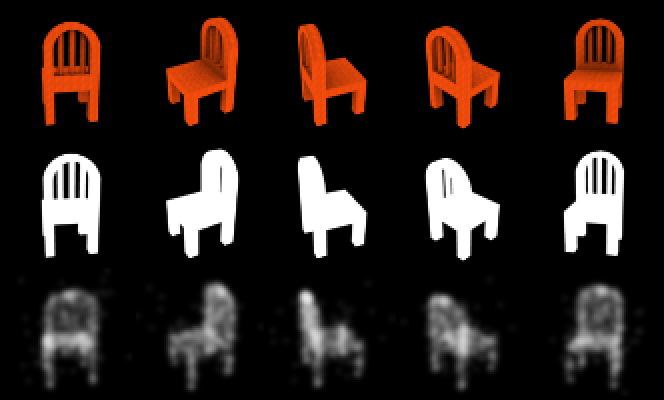

In [66]:
T.to_pil_image(generate_projections_img(model, img, cam, mask))

### Overfit one batch

In [145]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
torch.random.manual_seed(10)
imgs, cams, masks = next(iter(train_dl))

imgs = imgs.cuda()
cams = cams.cuda()
masks = masks.cuda()

for i in tqdm_notebook(range(1000)):
    proj = model(imgs, cams)
    targ = F.interpolate(masks.unsqueeze(0), scale_factor=1/2, mode='bilinear', align_corners=False).squeeze()

    loss = F.mse_loss(proj, targ, reduction='sum') / targ.size(0)
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    print(i, loss.item())

0 862.6303100585938
1 851.0328369140625
2 853.4484252929688
3 841.5902709960938
4 852.0188598632812
5 842.69189453125
6 841.8795776367188
7 857.0084228515625
8 852.7990112304688
9 844.146484375
10 853.1480712890625
11 853.1217041015625
12 841.2335205078125
13 847.189453125
14 845.0651245117188
15 840.2427978515625
16 844.7787475585938
17 843.8718872070312
18 841.1857299804688
19 840.2328491210938
20 843.7734375
21 848.7786254882812
22 851.2340087890625
23 833.6390991210938
24 841.78466796875
25 843.8678588867188
26 836.5084838867188
27 845.5076293945312
28 836.0003051757812
29 840.1427612304688
30 850.2421875
31 848.0466918945312
32 840.5307006835938
33 843.4773559570312
34 841.2628173828125
35 834.8250122070312
36 837.6051635742188
37 830.99853515625
38 834.689453125
39 839.279296875
40 835.4609375
41 827.9777221679688
42 833.4861450195312
43 830.86669921875
44 835.2279663085938
45 826.7252197265625
46 829.9605712890625
47 825.6588745117188
48 821.3147583007812
49 828.6643676757812
50

KeyboardInterrupt: 

In [130]:
proj = model(imgs, cams)

In [129]:
model.pc_dropout.keep_prob = 0.8

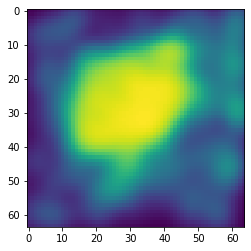

In [131]:
plt.imshow(proj[0].detach().cpu());

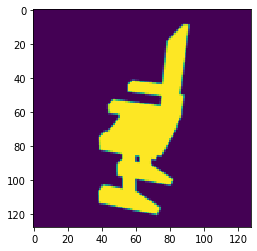

In [132]:
plt.imshow(masks[0].detach().cpu());

### Training loop

In [24]:
from torch.utils.tensorboard import SummaryWriter

In [25]:
def loopy(dl):
    "Loop through dataloader indefinitley"
    while True:
        for o in dl: yield o

In [26]:
def adjust_params(model, step, keep_prob=(0.07, 1.0), sigma=(3.0, 0.2)):
    "Schedule model parameters (dropout keep_prob and smoothing sigma)"
    assert 0 <= step <= 1

    new_keep_prob = keep_prob[0] * (1 - step) + keep_prob[1] * step
    new_sigma = sigma[0] * (1 - step) + sigma[1] * step
    
    model.pc_dropout.keep_prob = new_keep_prob
    model.pc_projection.sigma  = torch.empty_like(model.pc_projection.sigma).fill_(new_sigma)

In [43]:
def generate_projections_img(model, img, cam, mask):
    "Generate grid with model projections, gt projections and input images"
    proj = model(img[0].unsqueeze(0), cam).cpu()
    
    grid = torch.cat([
        F.interpolate(img, scale_factor=1/2, mode='bilinear', align_corners=True),
        F.interpolate(mask.unsqueeze(1), scale_factor=1/2, mode='bilinear', align_corners=True).repeat(1, 3, 1, 1),
        proj.unsqueeze(1).repeat(1, 3, 1, 1),
    ])
    
    grid = make_grid(grid, nrow=img.size(0))
    return F.interpolate(grid.unsqueeze(0), scale_factor=2).squeeze()

In [88]:
def train(path, steps=100_000, eval_every=10_000, vis_every=500, batch_size=10, lr=1e-3, wd=0.01):
    "Train model for `steps` iterations. Save logs and checkpoints to `path` folder"

    # Prepare
    try: 
        shutil.rmtree(path)
    except Exception:
        pass

    path = Path(path)
    path.mkdir(exist_ok=True, parents=True)
    writer = SummaryWriter(log_dir=path/'logs')
    pbar = tqdm_notebook(range(1, steps + 1), desc='Step')
    cuda = torch.cuda.is_available()
    torch.random.manual_seed(10)

    # Data
    train_ds = Shapenet(get_models(split="train"), num_views=5)
    valid_ds = Shapenet(get_models(split="valid"), num_views=5)
    train_dl = data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=multi_view_collate, drop_last=True, pin_memory=True, num_workers=4)
    valid_dl = data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False, collate_fn=multi_view_collate, pin_memory=True)
    train_dl = loopy(train_dl)

    model = SimpleModel()
    if cuda:
        model = model.cuda()
    
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    for step in pbar:
        model.train()
        adjust_params(model, step / steps)    
        t1 = time.perf_counter()
        imgs, cams, masks = next(train_dl)
        
        if cuda:
            imgs, cams, masks = imgs.cuda(), cams.cuda(), masks.cuda()
        
        proj  = model(imgs, cams)
        masks = F.interpolate(masks.unsqueeze(1), scale_factor=1/2, mode='bilinear', align_corners=False).squeeze()
        loss = F.mse_loss(proj, masks, reduction='sum') / masks.size(0)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        dt = time.perf_counter() - t1
  
        pbar.set_postfix(loss=loss.item(), time=dt)

        # logging
        writer.add_scalar('loss/train', loss.item(), step)
        writer.add_scalar('meta/sigma', model.pc_projection.sigma.item(), step)
        writer.add_scalar('meta/keep_prob', model.pc_dropout.keep_prob, step)
        
        if step % vis_every == 0:
            model.eval()
            writer.add_image('renders', generate_projections_img(model, *valid_ds[10]), step)
        
        if step % eval_every == 0:
            model.eval()
            with torch.no_grad():
                losses = []
                for imgs, cams, masks in tqdm_notebook(valid_dl, leave=False):
                    if cuda:
                        imgs, cams, masks = imgs.cuda(), cams.cuda(), masks.cuda()
                        
                        proj  = model(imgs, cams)
                        masks = F.interpolate(masks.unsqueeze(1), scale_factor=1/2, mode='bilinear', align_corners=False).squeeze()
                        loss = F.mse_loss(proj, masks, reduction='sum') / masks.size(0)
                        
                        losses.append(loss.item())
                loss = sum(losses) / len(losses)
                writer.add_scalar('loss/valid', loss, step)

                    
            torch.save(
                obj={
                    'model': model.state_dict(),
                    'opt': opt.state_dict(),
                    'step': step,
                }, 
                f=path/f"model_{step}.pth"
            )

            print(f"After step {step}: valid_loss={loss}")

In [ ]:
train('camera_supervision', lr=1e-4, eval_every=2000, vis_every=500)

After step 2000: valid_loss=363.7690418467802


After step 4000: valid_loss=309.61199322868794


After step 6000: valid_loss=283.0808233373305


After step 8000: valid_loss=266.8608200970818


After step 10000: valid_loss=249.98896632475012


After step 12000: valid_loss=234.5149937797995


After step 14000: valid_loss=232.55505191578584


After step 16000: valid_loss=217.41423595652861


After step 18000: valid_loss=212.9022061965045


After step 20000: valid_loss=207.95235667509192


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9a585ecae8>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9a585ecae8>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_w

After step 22000: valid_loss=207.03260444192324


After step 24000: valid_loss=199.57867274564856


After step 26000: valid_loss=197.17676566628847


After step 28000: valid_loss=197.36286230648264


After step 30000: valid_loss=191.2305959813735


After step 32000: valid_loss=187.73735517614028


After step 34000: valid_loss=192.5509131936466


After step 36000: valid_loss=184.3587606093463


After step 38000: valid_loss=195.30085328046013


After step 40000: valid_loss=175.77033906824448


After step 42000: valid_loss=177.0724722918342


After step 44000: valid_loss=173.28703173469094


After step 46000: valid_loss=170.22766674266143


After step 48000: valid_loss=170.8019676208496


After step 50000: valid_loss=168.25715480131262


After step 52000: valid_loss=168.72009636374082


After step 54000: valid_loss=163.13306527979233
